# Semantic Clustering
In this notebook we'll see how we can use pre-trained language models to embed text into fixed length vectors. The models we will use have been trained to produce embedding vectors that are close by if the input text has a similar semantic content! This can be useful for comparing chunks of text and performing vector based search!

In [33]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
import os
from tqdm.notebook import trange, tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
import numpy as np
from kneed import KneeLocator  # For automatic elbow detection


In [ ]:
print("CUDA Available:", torch.cuda.is_available())
print("GPU Count:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device() if torch.cuda.is_available() else "None")
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU Found")


In [34]:

# Load dataset
file_path = "Reviews.csv"  # Change if needed
df = pd.read_csv(file_path)


# Extract reviews from the "Text" column
narratives = df["Text"].dropna().iloc[:1000].tolist()  # Remove any NaN values

# Check required columns
assert "Score" in df.columns, "Missing 'Score' column!"
assert "Text" in df.columns, "Missing 'Text' column!"

# Keep only necessary columns and remove NaN values
df = df[["Score", "Text"]].dropna()

# Convert `Score` to binary labels (IMDB-style)
df["Score"] = df["Score"].apply(lambda x: 1 if x >= 4 else 0)  # 1 = Positive, 0 = Negative

# Convert text to lowercase
df["Text"] = df["Text"].str.lower()

# Define a PyTorch Dataset class
class AmazonReviewsDataset(Dataset):
    def __init__(self, data):
        self.data = list(zip(data["Score"].values, data["Text"].values))  # (label, text)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Split dataset (80% Train, 20% Test)
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_data, test_data = torch.utils.data.random_split(df, [train_size, test_size])

# Convert to Dataset format
dataset_train = AmazonReviewsDataset(train_data.dataset.iloc[train_data.indices])
dataset_test = AmazonReviewsDataset(test_data.dataset.iloc[test_data.indices])

# Apply IMDB-like formatting
def process_data(x):
    return x[0], x[1].lower()  # Label remains same, text is lowercased

dataset_train = list(map(process_data, dataset_train))
dataset_test = list(map(process_data, dataset_test))

# Shuffle (IMDB-style)
random.shuffle(dataset_train)
random.shuffle(dataset_test)

# Convert back to PyTorch Dataset format
class ProcessedDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset_train = ProcessedDataset(dataset_train)
dataset_test = ProcessedDataset(dataset_test)

# Create DataLoaders for training
data_loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
data_loader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

# ✅ Test Output: Print a sample
for label, text in data_loader_train:
    print(f"Label: {label[:5]}")  # First 5 labels
    print(f"Text: {text[:5]}")  # First 5 reviews
    break


Label: tensor([1, 1, 1, 1, 1])
Text: ("i've been drinking eden bagged teas since i saw them in a health food store in the 1990s.<br /><br />while the sencha and genmaicha are good (there are many brands of sencha out there, and i'm spoiled by the loose genmaicha from tealuxe), in my opinion the eden kukicha is outstanding. it's so good that i'm reluctant to try another bagged brand; however, i do look forward someday to trying the eden loose kukicha tea.<br /><br />this eden kukicha has the same very complex, earthy aroma and flavor that it had in the 1990s. i'm pleased that eden has maintained high standards for this tea.<br /><br />eden kukicha is almost impossible to ruin: i let water come to a good boil and steep the bag for at least 4-5 minutes.<br /><br />enjoy!", "this candy comes very close in taste to a real cup of double latte, though a tad sweeter. this does contain caffeine, so its not a decaf alternative to coffee, and its definitely not recommended for kids.<br /><br />pr

## Data processing and Tokenization

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.backends.cuda.matmul.allow_tf32 = True

# Approx number of text samples to use
num_data_points = 5000
# Define the batch size for mini-batch gradient descent
batch_size = 64

# Ensure device is properly set
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-small-en-v1.5')
model = AutoModel.from_pretrained('BAAI/bge-small-en-v1.5').to(device)
_ = model.eval()


c:\Users\susha\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create embedding model and tokenizer

In [9]:
# Ensure device is properly set
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load model
tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-small-en-v1.5')
model = AutoModel.from_pretrained('BAAI/bge-small-en-v1.5').to(device)
_ = model.eval()

print(f"Model successfully loaded on: {device}")


Model successfully loaded on: cuda:0


## Extract embeddings

In [10]:
from tqdm import tqdm  # Use standard tqdm instead of notebook version

embeddings_log = []
labels_log = []
text_log = []

# Loop over each batch in the training dataset
for label, text in tqdm(data_loader_train, desc="Extracting", leave=False, total=num_data_points//batch_size):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)

    with torch.cuda.amp.autocast():
        with torch.no_grad():
            embeddings = model(**encoded_input)[0][:, 0]
            
            norm_embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
            
            embeddings_log.append(norm_embeddings.cpu())
            labels_log.append(label)
            text_log += list(text)
            
    if len(labels_log) * batch_size >= num_data_points:
        break

Extracting:   0%|          | 0/78 [00:00<?, ?it/s]C:\Users\susha\AppData\Local\Temp\ipykernel_35888\2353433506.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
c:\Users\susha\anaconda3\envs\torch\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [11]:
np_embeddings = torch.cat(embeddings_log).numpy()
np_labels = torch.cat(labels_log).numpy()

## Cluster the Embedddings!

c:\Users\susha\anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\susha\anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\susha\anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\susha\anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will chang

Optimal number of clusters: 4


c:\Users\susha\anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


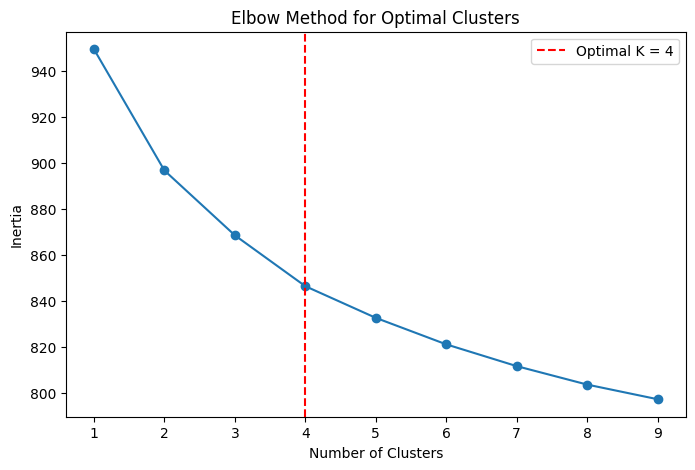

In [ ]:
# Sample Data: Replace np_embeddings with your real embeddings
# np_embeddings = np.random.rand(100, 5)  # Example data, shape (samples, features)

# Step 1: Find the optimal number of clusters using the Elbow Method
inertia = []
K_range = range(1, 10)  # Try different cluster sizes

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(np_embeddings)
    inertia.append(kmeans.inertia_)

# Step 2: Use KneeLocator to find the "elbow" point dynamically
knee_locator = KneeLocator(K_range, inertia, curve="convex", direction="decreasing")
optimal_clusters = knee_locator.elbow  # Automatically finds best K
n_clusters=optimal_clusters
# Step 3: Apply KMeans with the optimal cluster number
print(f"Optimal number of clusters: {optimal_clusters}")
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(np_embeddings)
cluster_centers = kmeans.cluster_centers_

# Plot Elbow Method Graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.axvline(x=optimal_clusters, color='red', linestyle='--', label=f'Optimal K = {optimal_clusters}')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.legend()
plt.show()


## Perform dimension reduction for visualization

In [14]:
# PCA Dim reduction
pca = PCA()

# Stack embs and centers to project together
combined_embs = np.vstack([np_embeddings, cluster_centers])
combined_pca = pca.fit_transform(combined_embs)

In [15]:
# TSNE Dim reduction (Maintain local distances)
tsne = TSNE(n_components=2, perplexity=50)
combined_2d = tsne.fit_transform(combined_pca)

# Separate the projected embeddings and centers
embeddings_2d = combined_2d[:-n_clusters]
centers_2d = combined_2d[-n_clusters:]

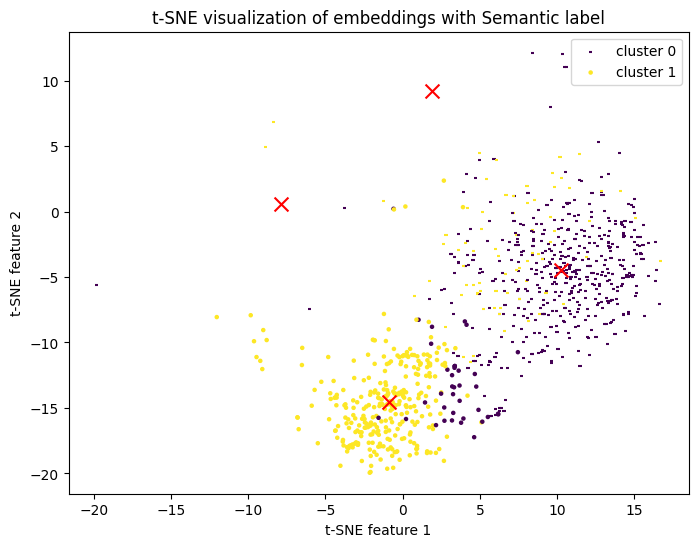

In [16]:
# Create a scatter plot
plt.figure(figsize=(8, 6))

cluster_0_index = np.where(cluster_labels == 0)[0]
scatter1 = plt.scatter(embeddings_2d[cluster_0_index, 0], embeddings_2d[cluster_0_index, 1], 
                      c=np_labels[cluster_0_index], s=5, marker="_")

cluster_1_index = np.where(cluster_labels == 1)[0]
scatter2 = plt.scatter(embeddings_2d[cluster_1_index, 0], embeddings_2d[cluster_1_index, 1], 
                      c=np_labels[cluster_1_index], s=5, marker="o")

_ = plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c="r", s=100, marker="x")
_ = plt.legend(["cluster 0", "cluster 1"])
_ = plt.xlabel('t-SNE feature 1')
_ = plt.ylabel('t-SNE feature 2')
_ = plt.title('t-SNE visualization of embeddings with Semantic label')

## Find outlier reviews

In [38]:
# Get the indices of all points in cluster 0
cluster_0_indices = np.where(cluster_labels == 0)[0]

# Get the labels and embeddings of points in cluster 0
cluster_0_labels = np_labels[cluster_0_indices]
cluster_0_points = np_embeddings[cluster_0_indices]

# Find the most common semantic label for this cluster
cluster_0_median_label = np.median(cluster_0_labels)
print("The most common semantic label is %d" % cluster_0_median_label)

The most common semantic label is 0


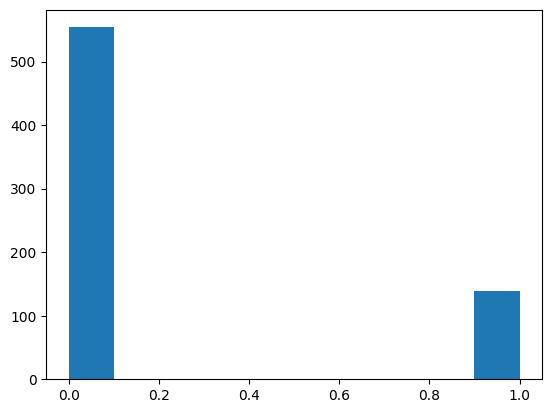

In [39]:
_ = plt.hist(cluster_0_labels)

In [40]:
# Get the cluster indices of points within this cluster that do not have the typical semantic label
outlier_indices = np.where(~(cluster_0_labels == cluster_0_median_label))[0]

# Get the origional indices for these points (to index text list)
cluster_0_outlier_indices = cluster_0_indices[outlier_indices]

# Get the embeddings of the outliers
cluster_0_outlier_points = cluster_0_points[outlier_indices]
cluster_0_outlier_labels = cluster_0_labels[outlier_indices]

## Find the worst outliers

In [41]:
# # Find the distance between each outlier embedding and the cluster center for cluster 0
points_diff = (cluster_0_outlier_points - cluster_centers[0].reshape(1, -1))
points_dist = np.mean(np.power(points_diff, 2), 1)

In [42]:
# Find the outlier that is closest to the cluster center
# AKA the "worst" outlier
closest_5 = np.argsort(points_dist)[:5]
closest_5_indices = cluster_0_outlier_indices[closest_5]

In [43]:
closest_5_indices

array([ 718,  444, 1234,  596, 2394], dtype=int64)

In [44]:
# Get the origional text for this outlier
outlier_text = text_log[closest_5_indices[0]]
outlier_label = np_labels[closest_5_indices[0]]

In [45]:
outlier_text

'i don\'t eat eggs, so oatmeal is my warm comfort food of choice for breakfast.  maple brown sugar is one of my "go to" flavors - it disappears from the variety pack first and it\'s the one i seek out at the store (along with apple).  i\'m also big on cutting costs at the grocery store, so i avoid name brands that aren\'t truly worth the extra money.  so, the important thing for me is how this oatmeal compares to the cheap stuff.<br /><br />there really is no comparison.  the store brands are a real disappointment.  the oats don\'t absorb the water properly.  the flavoring doesn\'t dissolve.  the texture is like someone threw confetti in hot water that was used to boil okra.  the taste is the cloying side.  on the other hand, quaker absorbs the water, the flavoring dissolves, the texture is nicely bumpy and three-dimensional, and the brown sugar is just enough.<br /><br />don\'t go cheap on oatmeal or you\'ll be sorry.  if you want to save a buck on your oatmeal, buy the real stuff in 

Optimal number of clusters: 4


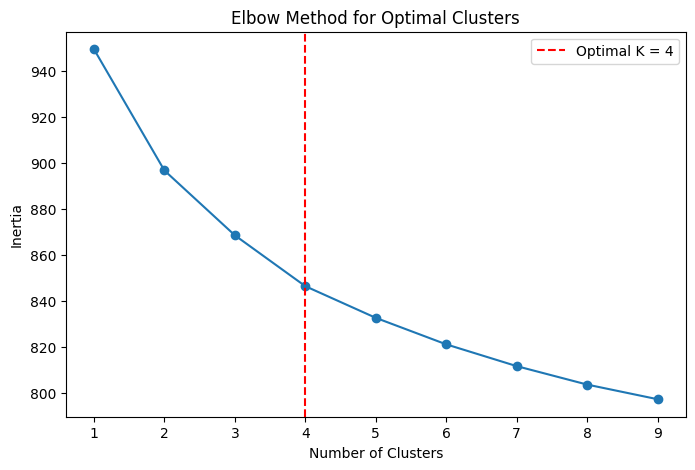

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from kneed import KneeLocator  # Automatic elbow detection

# Step 1: Find the optimal number of clusters using the Elbow Method
inertia = []
K_range = range(1, 10)  # Try different cluster sizes

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(np_embeddings)
    inertia.append(kmeans.inertia_)

# Step 2: Use KneeLocator to find the "elbow" point dynamically
knee_locator = KneeLocator(K_range, inertia, curve="convex", direction="decreasing")
optimal_clusters = knee_locator.elbow
print(f"Optimal number of clusters: {optimal_clusters}")

# Step 3: Apply KMeans with the optimal cluster number
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(np_embeddings)
cluster_centers = kmeans.cluster_centers_

# Plot Elbow Method Graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.axvline(x=optimal_clusters, color='red', linestyle='--', label=f'Optimal K = {optimal_clusters}')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.legend()
plt.show()


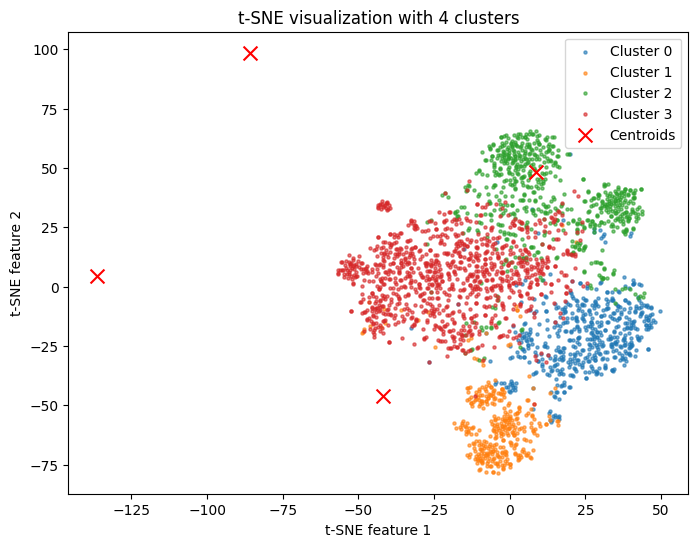

In [20]:
# Step 4: Reduce dimensions using PCA (to speed up t-SNE)
pca = PCA(n_components=50)  # Reduce dimensions first
pca_embeddings = pca.fit_transform(np_embeddings)

# Step 5: Use t-SNE for visualization (perplexity adjusted)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
embeddings_2d = tsne.fit_transform(pca_embeddings)

# Step 6: Reduce cluster centers using PCA (matching t-SNE transformation)
cluster_centers_pca = pca.transform(cluster_centers)

# Adjust perplexity to be less than n_clusters
center_perplexity = min(5, len(cluster_centers_pca) - 1)  # Ensure perplexity < n_samples

# Apply t-SNE to cluster centers with adjusted perplexity
tsne_centers = TSNE(n_components=2, perplexity=center_perplexity, random_state=42)
centers_2d = tsne_centers.fit_transform(cluster_centers_pca)

# Step 7: Create a scatter plot for each cluster dynamically
plt.figure(figsize=(8, 6))

for cluster_id in range(optimal_clusters):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    plt.scatter(
        embeddings_2d[cluster_indices, 0], embeddings_2d[cluster_indices, 1],
        s=5, label=f'Cluster {cluster_id}', alpha=0.6
    )

# Plot Cluster Centers
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c="red", s=100, marker="x", label="Centroids")

# Plot Settings
plt.legend()
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title(f't-SNE visualization with {optimal_clusters} clusters')
plt.show()


In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# import numpy as np

# # Step 1: Apply PCA to reduce dimensions (better for t-SNE stability)
# pca = PCA(n_components=50)
# pca_embeddings = pca.fit_transform(np_embeddings)
# pca_centers = pca.transform(cluster_centers)  # Apply same PCA transformation

# # Step 2: Apply t-SNE to Embeddings
# tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
# embeddings_2d = tsne.fit_transform(pca_embeddings)

# # 🔹 Step 3: Transform Cluster Centers Using the Same t-SNE Model
# centers_2d = tsne.transform(pca_centers)  # Correct way to align centroids

# # Step 4: Create Scatter Plot for Clusters
# plt.figure(figsize=(8, 6))

# for cluster_id in range(optimal_clusters):
#     cluster_indices = np.where(cluster_labels == cluster_id)[0]
#     plt.scatter(
#         embeddings_2d[cluster_indices, 0], embeddings_2d[cluster_indices, 1],
#         s=5, label=f'Cluster {cluster_id}', alpha=0.6
#     )

# # 🔹 Plot Correctly Aligned Cluster Centers
# plt.scatter(centers_2d[:, 0], centers_2d[:, 1], 
#             c="red", s=150, marker="x", label="Centroids")

# # Final Plot Settings
# plt.legend()
# plt.xlabel('t-SNE feature 1')
# plt.ylabel('t-SNE feature 2')
# plt.title(f"'t-SNE visualization with {optimal_clusters} clusters (Fixed Centroids)")
# plt.show()


AttributeError: 'TSNE' object has no attribute 'transform'

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
from community import community_louvain

# Compute cosine similarity matrix
cos_sim_matrix = cosine_similarity(np_embeddings)

# Define a threshold for similarity-based clustering (adjustable)
similarity_threshold = 0.7  

# Create a graph where nodes are reviews, edges exist if similarity > threshold
G = nx.Graph()
num_reviews = len(np_embeddings)

# Add nodes (reviews)
G.add_nodes_from(range(num_reviews))

# Add edges based on similarity threshold
for i in range(num_reviews):
    for j in range(i + 1, num_reviews):  
        if cos_sim_matrix[i, j] > similarity_threshold:
            G.add_edge(i, j)

# Apply community detection (Louvain method)
clusters = community_louvain.best_partition(G)

# Assign clusters to data
clustered_data = {
    "Cluster": [clusters[i] for i in range(num_reviews)],
    "Review": text_log,
    "Label": np_labels
}

# Create DataFrame to display results
# df_clustered = pd.DataFrame(clustered_data)

# Display clustered reviews
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Semantic Similarity Clusters", dataframe=df_clustered)


In [32]:
len_clusters = len(clusters)
len_reviews = len(text_log)
len_labels = len(np_labels)

(len_clusters, len_reviews, len_labels)

(100, 2528, 2528)